In [9]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import sampler
import math
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [10]:
#torch.cuda.set_device(0)
# specify dtype
use_cuda = torch.cuda.is_available()
if use_cuda:
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor
print(torch.cuda.device_count())
print(use_cuda)

1
True


In [11]:
# Hyperparameters
batch_size = 32
learning_rate = 4e-3
momentum = 0.9
num_epoch = 10

In [30]:
# Data
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start = 0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

data_path = '/data/put_data/frank840925/IDP/data'
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

trainset = torchvision.datasets.CIFAR10(root=data_path, 
                                        train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, 
                                          num_workers=3)

valset = torchvision.datasets.CIFAR10(root=data_path, 
                                       train=False, download=True, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, sampler=ChunkSampler(5000,0), 
                                        num_workers=3)

testset = torchvision.datasets.CIFAR10(root=data_path, 
                                       train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, sampler=ChunkSampler(5000,5000),
                                        num_workers=3)

print(trainset.__len__())
print(valset.__len__())
print(testset.__len__())

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
50000
10000
10000


In [31]:
# Helper functions
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def plot_losses(loss_history1=None, loss_history2=None):
    plt.clf()
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    if loss_history1:
        ax1.plot(loss_history1, color="blue", label="train")
    if loss_history2:
        ax1.plot(loss_history2, color="green", label="test")
    #ax2 = ax1.twinx()
    #ax2.set_yscale('log')
    plt.xlabel("epoch") 
    plt.ylabel("loss") 
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title("Cross-entropy loss")
    #plt.savefig('output_losses.png')

def plot_accuracy(accuracy1=None, accuracy2=None):
    plt.clf()
    fig2 = plt.figure()
    ax1 = fig2.add_subplot(111)
    if accuracy1:
        ax1.plot(accuracy1, color="red", label="train")
    if accuracy2:
        ax1.plot(accuracy2, color="black", label="val")
    plt.xlabel("epoch") 
    plt.ylabel("accuracy")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title("Train/Val accuracy") 
    #plt.savefig('accuracy.png')

# get some random training images
#dataiter = iter(trainloader)
#images, labels = dataiter.next()
#print(images.shape)

In [32]:
# self-defined modules(layers)
class Flatten(nn.Module):
    def forward(self, x):
        # read in N, C, H, W
        N, C, H, W = x.size()
        # flatten the C * H * W values into a single vector per image
        return x.view(N, -1)  
    
class idp_tensor(nn.Module):
    def __init__(self, idp):
        super(idp_tensor, self).__init__()
        self.idp = idp
    def forward(self, c):
        #c is an input tensor, size N*C*H*W
        N, C, H, W = c.size()
        non_zero_channel = int(C*(self.idp))
        if C-non_zero_channel > 0:
            zeros = Variable(torch.zeros(N, C-non_zero_channel, H, W)).type(dtype)
            c = torch.cat([c[:, :non_zero_channel, :, :].clone(), zeros], 1).type(dtype)
            #c[:, non_zero_channel:, :, :] = zeros
            return c
        else:
            return c
        
class first_idp_tensor(nn.Module):
    def __init__(self, idp1=0.5, idp2=1):
        super(first_idp_tensor, self).__init__()
        self.idp1 = idp1
        self.idp2 = idp2
    def forward(self, c):
        #input the first conv-Relu-Linear output, N*C*H*W, replicate and concat in first dim (N), 
        #first half apply IDP50, the other IDP100
        N, C, H, W = c.size()
        non_zero_channel_1 = int(C*(self.idp1))
        non_zero_channel_2 = int(C*(self.idp2))
        if C-non_zero_channel_1 > 0:
            zeros = Variable(torch.zeros(N, C-non_zero_channel_1, H, W)).type(dtype)
            c1 = torch.cat([c[:, :non_zero_channel_1, :, :].clone(), zeros], 1).type(dtype)
        else:
            c1 = c
        if C-non_zero_channel_2 > 0:
            zeros = Variable(torch.zeros(N, C-non_zero_channel_2, H, W)).type(dtype)
            c2 = torch.cat([c[:, :non_zero_channel_2, :, :].clone(), zeros], 1).type(dtype)
        else:
            c2 = c
        out = torch.cat([c1, c2], 0)
        return out
        
class middle_idp_tensor(nn.Module):
    def __init__(self, idp1=0.5, idp2=1):
        super(middle_idp_tensor, self).__init__()
        self.idp1 = idp1
        self.idp2 = idp2
    def forward(self, c):
        #input a middle conv-Relu-Linear output, 2N*C*H*W, apply IDP50 to first half, IDP100 the other
        NN, C, H, W = c.size()
        if NN>=2:
            N = int(NN/2)
            non_zero_channel_1 = int(C*(self.idp1))
            non_zero_channel_2 = int(C*(self.idp2))
            c1 = c[:N,:,:,:]
            c2 = c[N:,:,:,:]
            if C-non_zero_channel_1 > 0:
                zeros = Variable(torch.zeros(N, C-non_zero_channel_1, H, W)).type(dtype)
                c1 = torch.cat([c1[:, :non_zero_channel_1, :, :].clone(), zeros], 1).type(dtype)
            else:
                c1 = c1
            if C-non_zero_channel_2 > 0:
                zeros = Variable(torch.zeros(N, C-non_zero_channel_2, H, W)).type(dtype)
                c2 = torch.cat([c2[:, :non_zero_channel_2, :, :].clone(), zeros], 1).type(dtype)
            else:
                c2 = c2
            out = torch.cat([c1, c2],0)
            return out
        else:
            return c
        
class func_allone(nn.Module):
    def forward(self, x):
        #x is an input tensor, size N*C*H*W
        #for cnn, functions are applied to each filter
        N, C, H, W = x.size()
        x = torch.mul(x.clone(), Variable(torch.ones(N, C, H, W), requires_grad=False).type(dtype))
        return x

class func_linear(nn.Module):
    def __init__(self, k=1):
        super(func_linear, self).__init__()
        self.k = k
    def channel_coeff(self, N, C, H, W):
        #C is channels, return a list with corresponding index: [k, k/2,...]
        #returns a tensor with size N*C*H*W
        coeff = list(map(lambda a: 1-(a/(C+1)), range(0,C)))
        tensor_list = []
        for c in coeff:
            coeff_tensor = torch.ones(H, W)
            coeff_tensor = torch.mul(coeff_tensor, c)
            tensor_list.append(coeff_tensor)
        ct = torch.stack(tensor_list, 0)
        ct = torch.stack(([ct]*N))
        return ct
    
    def forward(self, x):
        N, C, H, W = x.size()
        x = torch.mul(x.clone(), Variable(self.channel_coeff(N, C, H, W), requires_grad=False).type(dtype))
        return x
        
class func_harmonic(nn.Module):
    #perform element-wise multiplication to channels in x with coefficient k/n, n is channel index
    def __init__(self, k=1):
        super(func_harmonic, self).__init__()
        self.k = k
    def channel_coeff(self, N, C, H, W):
        #C is channels, return a list with corresponding index: [k, k/2,...]
        #returns a tensor with size N*C*H*W
        coeff = list(map(lambda a: self.k/a, range(1,C+1)))
        tensor_list = []
        for c in coeff:
            coeff_tensor = torch.ones(H, W)
            coeff_tensor = torch.mul(coeff_tensor, c)
            tensor_list.append(coeff_tensor)
        ct = torch.stack(tensor_list, 0)
        ct = torch.stack(([ct]*N))
        return ct
    
    def forward(self, x):
        #x is an input tensor, size N*C*H*W
        #for cnn, functions are applied to each filter
        N, C, H, W = x.size()
        x = torch.mul(x.clone(), Variable(self.channel_coeff(N, C, H, W), requires_grad=False).type(dtype))
        return x

In [33]:
class tesla_coef_idp_VGG_branch(nn.Module):
    def __init__(self, idp_layers, model=models.vgg16(pretrained=True).type(dtype), idp1=0.5, idp2=1):
        #idp is 0~1, idp_layers is a set, specify which layer in features should apply idp
        #now idp_layers is 3,6,8,11,13,15,18,20,22,25,27,29
        super(tesla_coef_idp_VGG_branch, self).__init__()
        self.idp1 = idp1
        self.idp2 = idp2
        self.idp_layers = idp_layers
        self.features = nn.Sequential(*(self.new_features_list(model)))
        self.classifier = nn.Sequential(nn.Linear(512, 512),
                              nn.ReLU(inplace=True),
                              nn.Dropout(0.5),
                              nn.Linear(512, 10))
        
    
    def new_features_list(self, model):
        new_layers = []
        #create from pre-trained resnet
        for i, layer in enumerate(list(model.features.children())):
            if i ==1:
                new_layers.append(layer)
                new_layers.append(func_linear())
                new_layers.append(first_idp_tensor(self.idp1, self.idp2))
            elif i not in self.idp_layers:
                new_layers.append(layer)                
            else:
                new_layers.append(layer)
                new_layers.append(func_linear())
                new_layers.append(middle_idp_tensor(self.idp1, self.idp2))
        new_layers.append(Flatten())
        return new_layers        
    
    def forward(self, x):
        f = self.features(x)
        NN, M = f.size()
        N = int(NN/2)
        o1 = f[:N, :]
        o2 = f[N:, :]
        o1 = self.classifier(o1)
        o2 = self.classifier(o2)
        return o1, o2

In [20]:
# test the model by forward pass, output size
idp_layers = {3,6,8,11,13,15,18,20,22,25,27,29}
net = tesla_coef_idp_VGG_branch(idp_layers, idp1=0.3, idp2=1).type(dtype)

x = Variable(torch.randn(32, 3, 32, 32)).type(dtype)
out1, out2 = net(x)
print(out1.size())
print(out2.size())

torch.Size([32, 10])
torch.Size([32, 10])


In [34]:
def train_tesla(num_epoch, net, criterion, optimizer, alpha=0, index=0):
    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []

    # start training
    for epoch in range(num_epoch):  # loop over the dataset multiple times
        running_loss1 = []
        running_loss2 = []
        running_correct1=[]
        running_correct2=[]
        for i, data in enumerate(trainloader, 0):
            correct = 0
            net.train(True)
            # get the inputs
            inputs, labels = data
            # wrap them in Variable
            inputs, labels = Variable(inputs).type(dtype), Variable(labels).type(torch.cuda.LongTensor)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            loss1 = criterion(outputs[0], labels)
            loss2 = criterion(outputs[1], labels)
            loss = alpha*loss1+(1-alpha)*loss2
            
            loss.backward()
            optimizer.step()
            # print statistics
            # loss
            running_loss1.append(loss.data[0])
            # accuracy
            _, predicted = torch.max(outputs[index].data, 1)
            correct += (predicted == labels.data).sum()
            correct = correct/labels.size(0)*100
            running_correct1.append(correct)

        for i, tdata in enumerate(valloader, 0):
            test_correct = 0
            net.train(False)
            tinputs, tlabels = tdata
            tinputs, tlabels = Variable(tinputs).type(dtype), Variable(tlabels).type(torch.cuda.LongTensor)
            toutputs = net(tinputs)
            tloss1 = criterion(toutputs[0], tlabels)
            tloss2 = criterion(toutputs[1], tlabels)
            tloss = alpha*tloss1+(1-alpha)*tloss2
            running_loss2.append(tloss.data[0])
            _, tpredicted = torch.max(toutputs[index].data, 1)
            test_correct += (tpredicted == tlabels.data).sum()
            test_correct = test_correct/tlabels.size(0)*100
            running_correct2.append(test_correct)

        train_loss.append(np.mean(running_loss1))
        test_loss.append(np.mean(running_loss2))
        train_acc.append(np.mean(running_correct1))
        test_acc.append(np.mean(running_correct2))

        #statistics
        print('Epoch [%d/%d], Train Loss:%.3f, Val Loss:%.3f, Train Accuracy:%.3f percent, Val Accuracy:%.3f percent' 
                    %(epoch+1, num_epoch, train_loss[-1], test_loss[-1], train_acc[-1], test_acc[-1]))
        #save model every 10 epoch
        if epoch%10 ==0:
            file = 'saved_models/'+str(epoch)+'profile_linear_idp_model.pkl'
            torch.save(net.state_dict(), file)
        #early stopping
        if epoch >= 3:
            if (test_acc[-1] - test_acc[-2]) <=0 and (test_acc[-1] - test_acc[-3]) <= 0:
                print('Early stopping')
                return train_loss, test_loss, train_acc, test_acc
            else:
                continue
        
    print('Finished Training')
    return train_loss, test_loss, train_acc, test_acc

In [35]:
# loss and optimizer
#optimizer = optim.SGD([{'params': net.features.parameters()},
#                       {'params': net.classifier.parameters(), 'lr': 1e-3}], lr=3e-4, momentum=momentum)

In [36]:
# define models, optimizers, training
idp_ranges = [0.5, 1]
all_train_loss = []
all_test_loss = []
all_train_acc = []
all_test_acc = []

idp_layers = {1,3,6,8,11,13,15,18,20,22,25,27,29}

criterion = nn.CrossEntropyLoss()
net = tesla_coef_idp_VGG_branch(idp_layers, idp1=0.5, idp2=1).type(dtype)
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

for index, idp in enumerate(idp_ranges):
    if index == 0:
        print('train with idp1')
        train_loss, test_loss, train_acc, test_acc = train_tesla(num_epoch, net, criterion, optimizer, 1, 0)
        all_train_loss.extend(train_loss)
        all_test_loss.extend(test_loss)
        all_train_acc.extend(train_acc)
        all_test_acc.extend(test_acc)
    else:
        print('train with idp2')
        train_loss, test_loss, train_acc, test_acc = train_tesla(num_epoch, net, criterion, optimizer, 0.5, 1)        
        all_train_loss.extend(train_loss)
        all_test_loss.extend(test_loss)
        all_train_acc.extend(train_acc)
        all_test_acc.extend(test_acc)

train with idp1
Epoch [1/10], Train Loss:2.304, Val Loss:2.303, Train Accuracy:9.867 percent, Val Accuracy:10.032 percent
Epoch [2/10], Train Loss:2.178, Val Loss:1.848, Train Accuracy:14.199 percent, Val Accuracy:22.273 percent
Epoch [3/10], Train Loss:1.739, Val Loss:1.516, Train Accuracy:27.897 percent, Val Accuracy:38.873 percent
Epoch [4/10], Train Loss:1.407, Val Loss:1.220, Train Accuracy:42.892 percent, Val Accuracy:53.961 percent
Epoch [5/10], Train Loss:1.081, Val Loss:0.947, Train Accuracy:60.781 percent, Val Accuracy:65.784 percent
Epoch [6/10], Train Loss:0.864, Val Loss:0.788, Train Accuracy:69.956 percent, Val Accuracy:73.826 percent
Epoch [7/10], Train Loss:0.729, Val Loss:0.737, Train Accuracy:75.428 percent, Val Accuracy:75.637 percent
Epoch [8/10], Train Loss:0.637, Val Loss:0.720, Train Accuracy:78.979 percent, Val Accuracy:75.876 percent
Epoch [9/10], Train Loss:0.556, Val Loss:0.622, Train Accuracy:81.518 percent, Val Accuracy:80.016 percent
Epoch [10/10], Train L

In [37]:
# Save the Model
torch.save(net.state_dict(), 'saved_models/tesla_branch_linear_idp_model.pkl')

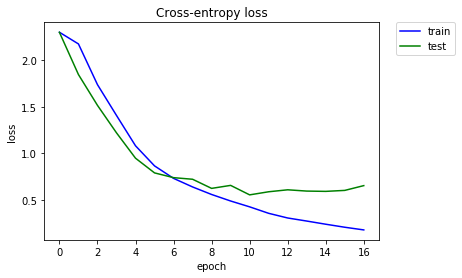

In [38]:
plot_losses(all_train_loss, all_test_loss)

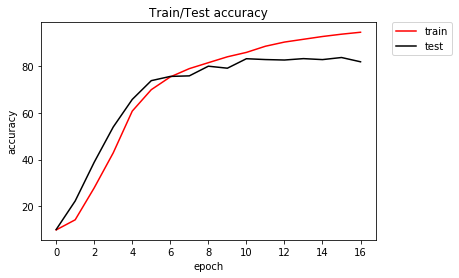

In [39]:
plot_accuracy(all_train_acc, all_test_acc)

In [40]:
# Load the trained model
net.load_state_dict(torch.load('saved_models/tesla_branch_linear_idp_model.pkl'))

In [41]:
def test_acccuracy(testloader, model):
    correct = 0
    total = 0
    for data in testloader:
        images, labels = data
        outputs1, outputs2 = model.forward(Variable(images, volatile=True).type(dtype))
        labels = Variable(labels, volatile=True).type(torch.cuda.LongTensor)
        _, predicted = torch.max(outputs2.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.data).sum()
    acc = 100*correct/total
    print('Accuracy of the network on the 10000 test images: %d %%' % (acc))
    return acc

test_acccuracy(testloader, net.eval())

Accuracy of the network on the 10000 test images: 82 %


82.82

In [42]:
idp_acc_history = []
idp_harmonic_history = [0]*20

idp_scale = list(map(lambda x: x/20,range(1,21)))
print(idp_scale)
for i in idp_scale:
    net_inference = tesla_coef_idp_VGG_branch(idp_layers, idp1=1, idp2=i).type(dtype)
    net_inference.load_state_dict(torch.load('saved_models/tesla_branch_linear_idp_model.pkl'))
    a = test_acccuracy(testloader, net_inference.eval())
    idp_acc_history.append(a)

[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
Accuracy of the network on the 10000 test images: 10 %
Accuracy of the network on the 10000 test images: 10 %
Accuracy of the network on the 10000 test images: 9 %
Accuracy of the network on the 10000 test images: 10 %
Accuracy of the network on the 10000 test images: 9 %
Accuracy of the network on the 10000 test images: 11 %
Accuracy of the network on the 10000 test images: 28 %
Accuracy of the network on the 10000 test images: 63 %
Accuracy of the network on the 10000 test images: 76 %
Accuracy of the network on the 10000 test images: 81 %
Accuracy of the network on the 10000 test images: 81 %
Accuracy of the network on the 10000 test images: 81 %
Accuracy of the network on the 10000 test images: 82 %
Accuracy of the network on the 10000 test images: 82 %
Accuracy of the network on the 10000 test images: 82 %
Accuracy of the network on the 10000 test images: 82 %
Accuracy of

In [43]:
idp_acc_history

[10.06,
 10.06,
 9.76,
 10.5,
 9.82,
 11.64,
 28.34,
 63.36,
 76.0,
 81.82,
 81.12,
 81.56,
 82.0,
 82.26,
 82.38,
 82.6,
 82.54,
 82.4,
 82.84,
 82.82]

In [44]:
profile = [10.06,
 10.06,
 10.24,
 10.24,
 9.8,
 11.58,
 17.32,
 45.62,
 65.78,
 73.66,
 75.22,
 76.98,
 78.8,
 79.96,
 80.4,
 80.94,
 81.2,
 81.2,
 81.62,
 81.58]

In [45]:
all_one_acc_history = [10.0,
 10.0,
 10.0,
 10.0,
 10.01,
 10.0,
 10.05,
 9.97,
 9.98,
 10.04,
 10.4,
 10.0,
 10.53,
 15.1,
 20.53,
 24.51,
 33.01,
 46.47,
 69.54,
 84.88]

In [46]:
linear_history = [10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.01,
 12.02,
 14.02,
 18.1,
 29.97,
 53.39,
 70.65,
 80.72,
 83.42,
 85.51,
 85.85,
 86.11,
 86.2]

In [47]:
def plot_idp_accuracy(accuracy1=None, accuracy2=None, accuracy3=None, accuracy4=None):
    plt.clf()
    fig4 = plt.figure()
    ax1 = fig4.add_subplot(111)
    idp_scale = list(map(lambda x: x/20,range(1,21)))
    idp_scale_i = [i for i in range(0, len(idp_scale))]
    if accuracy1:
        ax1.plot(idp_scale_i, accuracy1, marker='o', linestyle='-', color='r', label="all-one")
    if accuracy2:
        ax1.plot(idp_scale_i, accuracy2, marker='o', linestyle='--', color='g', label="Linear")
    if accuracy3:
        ax1.plot(idp_scale_i, accuracy3, marker='o', linestyle='--', color='b', label="Profile-Linear")
    if accuracy4:
        ax1.plot(idp_scale_i, accuracy4, marker='o', linestyle='--', color='y', label="Tesla-Linear")
    plt.xticks(idp_scale_i, idp_scale)
    plt.xlabel("IDP") 
    plt.ylabel("Accuracy(%)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title("VGG(CIFAR-10)") 
    plt.savefig('results_graphs/tesla_branch_linear_idp_accuracy.png')

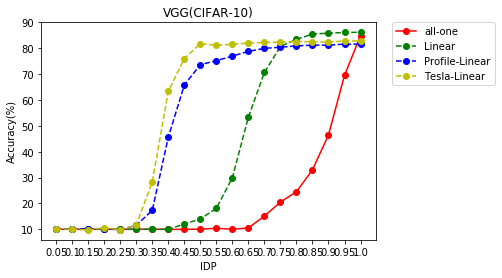

In [48]:
plot_idp_accuracy(all_one_acc_history,linear_history, profile,idp_acc_history)